In [6]:
import numpy as np
import mtalg
from mtalg.random import MultithreadedRNG
import pickle
from tqdm import tqdm
import scipy
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 8)


# import Coin_Press_Functions
# import PD_Median_Functions
import PD_Median_Functions_opt_for_sims
# import Private_Tukey_Med_Functions

In [7]:
########### Generate the datasets, unit vectors for the PD median and starting values for the MCMC/GD and save in folders
########## This is useful for reproducibility and makes the code slightly faster
#Number of runs in the experiment
num_runs=50
#maximum dimension analysed
d=100
#sample size
ndata=10000
#portion of data contaminated
con_level=0.25


##### First generate the datasets and pickle them #####
# Build a contaminating matrix to add to data to create contaminated datasets
#number of observations contaminated
total=int(con_level*ndata)
# matrix of 5s with total rows
mean_contam=np.full((total,d),5)
# matrix of 0s with n-total rows
mean_clean=np.full((ndata-total,d),0)
# n x d matrix with con_level of rows equal to 5, the rest 0
contam_mat=np.vstack([mean_contam,mean_clean])

# This allows us to set the seed with the mtalg package
mrng = MultithreadedRNG(seed=421, num_threads=10)

#generate the data and write to files
for run in tqdm(range(num_runs)):
    #the clean dataset
    data_clean=mrng.standard_normal(size=(ndata,d))
    #add contamination matrix
    data_con=data_clean+contam_mat
    #now pickle it for reloading later
    #pickle 1
    fn="data/data_set_clean_"+str(run)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(data_clean,file)
    #pickle 2
    fn="data/data_set_con_"+str(run)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(data_con,file)


##### Second generate the unit vectors to be used with s-IDD ##### 
#number of unit vectors
nvec=20000
#dimensions in the experiment
dimensions=[2,10,20,50,100]

# This allows us to set the seed with the mtalg package
mrng = MultithreadedRNG(seed=422, num_threads=10)
# Generate unit vectors and save them for later
for d in tqdm(dimensions):
    for run in range(num_runs):
        unit_vectors=mrng.standard_normal(size=(nvec,d))
        for i in range(0,nvec):
            unit_vectors[i,:]=unit_vectors[i,:]/np.linalg.norm(unit_vectors[i,:])
    #now pickle it for reloading
        fn="unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(unit_vectors,file)



#### Third generate the starting values for langevin and gradient descent #### 

mrng = MultithreadedRNG(seed=423, num_threads=10)
#generate uv and save them for later
for d in tqdm(dimensions):
    for run in range(num_runs):
        start=mrng.standard_normal(size=d)
    #now pickle it for reloading
        fn="starting/starting_dimension_"+str(d)+"_run_"+str(run)+".pickle"
        with open(fn,"wb") as file:
            pickle.dump(start,file)




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.79it/s]


In [8]:

# This function returns one run of the simulation experiment for a given run_number
# OUTPUT:
# x:  the Markov chain for the private median 
# x2: the iterations of the gradient descent for the non-private median 
# cp: coin-press mean 
# INPUT: 
# run_number: the number from 1-50 corresponding to the simulation run
# d: integer dimension
# eps: pure privacy parameter
# smooth: float, value of the smoothing parameter "s"
# x: d x 1 numpy array for point at which depth is computed
# nvec: integer number of unit vectors sampled
# ndata: integer sample size
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation
def experiment(run_number,fn_dict,d,tau,eta,eps,delta,nvec,n_steps_gd,n_steps_mc,step_g,step_l,data_type='clean',ndata=100):
    # set the seed for the langevin dynamics to be the run number
    # this way we can reproduce the chain 
    # only use 1 thread because we are on the gpu
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    # load in data, unit vectors and starting value
    with open("data/data_set_"+data_type+"_"+str(run_number)+".pickle",'rb') as file:
        data=pickle.load(file)
    data=data[0:ndata,0:d]
    with open("unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        unit_vectors=pickle.load(file)
        unit_vectors=unit_vectors[0:nvec,:]
    with open("starting/starting_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        x0=pickle.load(file)
    # move data to GPU
    data=cp.asarray(data)
    x0=cp.asarray(x0)
    unit_vectors=cp.asarray(unit_vectors)
    IV=PD_Median_Functions_opt_for_sims.get_initial_values(unit_vectors,data,fn_dict['mu'],fn_dict['sigma'])
    ###### MCMC-lagevin dyanmics for private median
    x_p=PD_Median_Functions_opt_for_sims.compute_PTR_PD_Median(data,fn_dict,tau,eta,eps,delta,IV=IV,
                            nvec=unit_vectors.shape[0],mrng=mrng,step_l=step_l,nstep=n_steps_mc,u=unit_vectors,x0=x0,return_chain=True,joint=True)
    # if x_p=="Test failed":
    ###### Gradient Descent for non-private median
    x_np=PD_Median_Functions_opt_for_sims.non_private_pd(IV,unit_vectors,d,step_g,nstep=n_steps_gd,plot=False,x0=x0,return_chain=True)
    
    return x_p,x_np

# This function plots and saves the results from each experiment. 
# It writes the progression of the GD and MCMC to text files, the mean to a text file
# It plots the chains over time with the cp mean overlaid
# INPUT: 
# results: list of results from 50 runs of the simulations
# d: integer dimension
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation
def plot_and_save(results,d,n_steps_gd,n_steps_mc,data_type='clean',tag='unsp'):
    pr_est=np.zeros(d)
    np_est=np.zeros(d)
    colors= viridis(range(8))
    count=0
    for i in results:
        x_p,x_np = i
        #pr
        x_p = [x.get() for x in x_p]
        x_p = np.vstack(x_p)
        # print(x_p.shape)
        norm_x_p = np.linalg.norm(x_p,axis=1)
        # print(np.vstack(x_p).shape)
        # pr_est=np.vstack([pr_est,x_p[n_steps_mc-1,:]])
        pr_est=x_p[-1,:]
        ##np
        x_np = [x.get() for x in x_np]
        x_np = np.vstack(x_np)
        norm_x_np = np.linalg.norm(x_np,axis=1)
        # print(norm_x_np.shape)
        np_est=x_np[-1,:]
        # np_est=np.vstack([np_est,x_np[n_steps_gd-1,:]])
        if count==0:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0],label=r'private pd median')
            plt.plot(np.arange(n_steps_gd+1),norm_x_np,color=colors[4],label=r'non-private pd median')
            plt.ylabel('estimate norm', fontsize=18)
            plt.xlabel('time step', fontsize=18)
            plt.legend(fontsize=18)
        else:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0])
            plt.plot(np.arange(n_steps_gd+1),norm_x_np,color=colors[4])
        count=count+1
    # plt.show()
    #save the plot
    fname='out_img/'+tag+'_pd_dimension_'+str(d)+"_"+data_type+"_gaussian.png"
    plt.savefig(fname,dpi=600)
    plt.show()
    #save the estimates to a csv
    fn_p="output/"+tag+"_private_pd_results_dimension_"+str(d)+"_"+data_type+".csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_est, delimiter=",")   
    fn_p.close()
    fn_np="output/"+tag+"non_private_pd_results_dimension_"+str(d)+"_"+data_type+".csv"
    fn_np=open(fn_np, 'w', newline='')
    np.savetxt(fn_np, np_est, delimiter=",")
    fn_np.close()



In [9]:
# #testing experiment parameters
# d=100
# num_runs=int(2)
# ndata=10000
# nvecs=[2500,2500,2500,2500,2500]
# nsteps_gd=[300,500,800,3000,5000]
# nsteps_mc=[300,500,800,3000,5000]
# gd=0.025
# gd_step_sizes=[gd,gd,gd,gd,gd]
# mc=0.0002
# mc_step_sizes=[mc,mc,mc,mc,mc]
# dimensions=[2,10,20,50,100]
# dimensions=[2,10,20]

In [10]:
# #parameters for testing to make sure the simulation actually runs. 
# d=2
# num_runs=int(2)
# ndata=10000
# nvec=500
# nsteps_gd=[150,300,600,3000,5000]
# nsteps_mc=[150,300,600,3000,5000]
# gd=0.025
# gd_step_sizes=[gd,gd,gd,gd,gd]
# mc=0.0002
# mc_step_sizes=[mc,mc,mc,mc,mc]
# dimensions=[2,10,20,50,100]
# # dimensions=[2]


In [11]:
#prelinminary experiment parameters
d=100
num_runs=int(50)
# num_runs=int(5)
ndata=10000
nvecs=[500,500,1000,2500,2500]
nsteps_gd=[500,800,1000,3000,5000]
nsteps_mc=[500,800,1000,3000,5000]
gd=0.025
gd_step_sizes=[gd,gd,gd,gd,gd]
mc=0.00015
taus=[]
# mc=0.0005
mc_step_sizes=[mc,mc,mc,mc,mc]
# dimensions=[2,10,20,50,100]
dimensions=[2,10,20]

# tau=2
# # tau=8
# eta=20*cp.log(n)/n
# print('eta',eta)
# delta=10/n
# eps=10
# mrng = MultithreadedRNG(seed=421, num_threads=10)
# data=mrng.standard_normal(size=(n,d))


In [5]:
30*cp.log(ndata)/ndata

array(0.02763102)

starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [54:12<00:00, 65.06s/it]


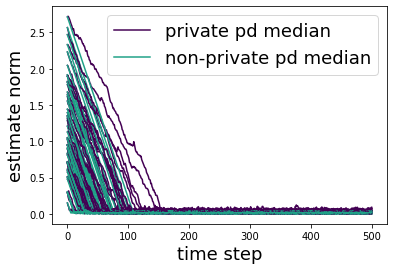

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [55:58<00:00, 67.16s/it]


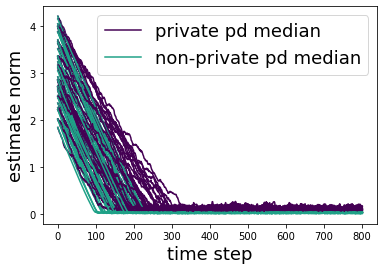

starting dimension 20


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:49:30<00:00, 131.41s/it]


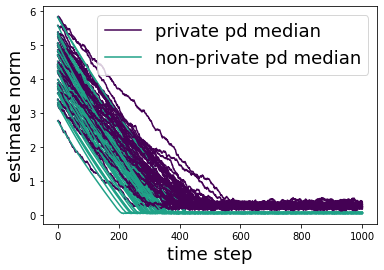

In [12]:
fn_dict_med_mad={
     'mu': PD_Median_Functions_opt_for_sims.med,
     'sigma': PD_Median_Functions_opt_for_sims.mad,
     'Smu': PD_Median_Functions_opt_for_sims.S_med,
     'Ssigma': PD_Median_Functions_opt_for_sims.S_mad,
     'bhat': PD_Median_Functions_opt_for_sims.b_hat_mad,
     'joint': PD_Median_Functions_opt_for_sims.S_med_mad_b_joint,
     'mad_flag': True
}


# Simplified wrapper for the experiment function for the clean experiment with identity prior covariance
def m_experiment(run_number,d,gd_step, mc_step_size ,nstep_gd,nstep_mc,nvec):
    x_p,x_np=experiment(run_number,fn_dict_med_mad,d,5,30*cp.log(ndata)/ndata,10,10/ndata,nvec,nstep_gd,nstep_mc,gd_step,mc_step_size,data_type='clean',ndata=ndata)
    return x_p,x_np


# run the experiment for the clean data
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step_size=gd_step_sizes[i]
    mc_step_size=mc_step_sizes[i]
    nstep_gd=nsteps_gd[i]
    nstep_mc=nsteps_mc[i]
    nvec=nvecs[i]
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=m_experiment(j,d,gd_step_size, mc_step_size,nstep_gd,nstep_mc,nvec)
        if result_j[0]=="Test failed":
            print(j)
            break
        results.append(result_j)
    plot_and_save(results,d,nstep_gd,nstep_mc,data_type='clean',tag='med_mad')
        # #save the chains too in case we want to modify the graphs
    fn="output/delta_med_mad_results_clean_dimension_"+str(d)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)



starting dimension 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [54:02<00:00, 64.85s/it]


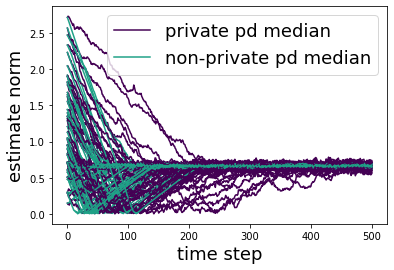

starting dimension 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [54:23<00:00, 65.26s/it]


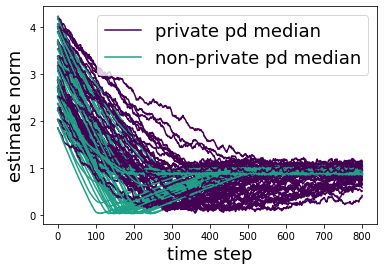

starting dimension 20


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:48:16<00:00, 129.94s/it]


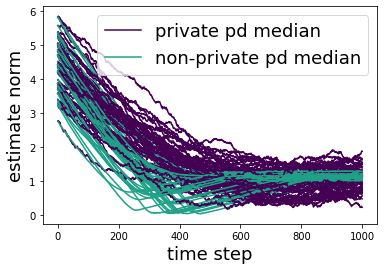

In [13]:
fn_dict_med_mad={'mu': PD_Median_Functions_opt_for_sims.med,
     'sigma': PD_Median_Functions_opt_for_sims.mad,
     'Smu': PD_Median_Functions_opt_for_sims.S_med,
     'Ssigma': PD_Median_Functions_opt_for_sims.S_mad,
     'bhat': PD_Median_Functions_opt_for_sims.b_hat_mad,
    'joint': PD_Median_Functions_opt_for_sims.S_med_mad_b_joint,
    'mad_flag': True
    }


# Simplified wrapper for the experiment function for the clean experiment with identity prior covariance
def m_experiment(run_number,d,gd_step, mc_step_size ,nstep_gd,nstep_mc,nvec):
    x_p,x_np=experiment(run_number,fn_dict_med_mad,d,5,30*cp.log(ndata)/ndata,10,10/ndata,nvec,nstep_gd,nstep_mc,gd_step,mc_step_size,data_type='con',ndata=ndata)
    return x_p,x_np


# run the experiment for the clean data
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step_size=gd_step_sizes[i]
    mc_step_size=mc_step_sizes[i]
    nstep_gd=nsteps_gd[i]
    nstep_mc=nsteps_mc[i]
    nvec=nvecs[i]
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=m_experiment(j,d,gd_step_size, mc_step_size,nstep_gd,nstep_mc,nvec)
        if result_j[0]=="Test failed":
            print(j)
            break
        results.append(result_j)
    plot_and_save(results,d,nstep_gd,nstep_mc,data_type='con',tag='med_mad')
        # #save the chains too in case we want to modify the graphs
    fn="output/delta_med_mad_results_con_dimension_"+str(d)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)



In [ ]:
#finding the fastest median function
# n=10000
# data=np.random.standard_normal(n)
# q=int(n/2)
# for j in tqdm(range(100)):
#     np.partition(data,q)[q]
# for j in tqdm(range(100)):
#     np.median(data)
# for j in tqdm(range(100)):
#     np.percentile(data, 50)

In [29]:
fn_mm="output/delta_med_mad_results_con_dimension_"+str(d)+".pickle"
# fn_hm="output/hub_mad_results_con_dimension_"+str(d)+".pickle"
with open(fn_mm,"rb") as file:
    results_mm=pickle.load(file)
# with open(fn_hm,"rb") as file:
#     results_hm=pickle.load(file)

In [14]:
# Now make graphs for manuscript
viridis = cm.get_cmap('viridis', 8)
colors= viridis(range(8))
d=10
def get_mses(d):
    fn_mm="output/delta_med_mad_results_con_dimension_"+str(d)+".pickle"
    fn_hm="output/hub_mad_results_con_dimension_"+str(d)+".pickle"
    with open(fn_mm,"rb") as file:
        results_mm=pickle.load(file)
    with open(fn_hm,"rb") as file:
        results_hm=pickle.load(file)
    # print(len(results))
    x_pdmm_mse=0
    x_npdmm_mse=0
    for i in tqdm(results_mm):
        x_pdmm,x_npdmm = i
        x_pdmm=  np.array([x.get() for x in x_pdmm])
        x_npdmm = np.array([x.get() for x in x_npdmm])
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_pdmm_mse=x_pdmm_mse+np.linalg.norm(x_pdmm[x_pdmm.shape[0]-1,:])**2
        x_npdmm_mse=x_npdmm_mse+np.linalg.norm(x_npdmm[x_npdmm.shape[0]-1,:])**2
    
    x_pdhm_mse=0
    x_npdhm_mse=0
    for i in tqdm(results_hm):
        x_pdhm,x_npdhm = i
        x_pdhm=  np.array([x.get() for x in x_pdhm])
        x_npdhm = np.array([x.get() for x in x_npdhm])
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_pdhm_mse=x_pdhm_mse+np.linalg.norm(x_pdhm[x_pdhm.shape[0]-1,:])**2
        x_npdhm_mse=x_npdhm_mse+np.linalg.norm(x_npdhm[x_npdhm.shape[0]-1,:])**2
    x_pdhm_mse=x_pdhm_mse/len(results_hm)
    x_pdmm_mse=x_pdmm_mse/len(results_mm)
    x_npdhm_mse=x_npdhm_mse/len(results_hm)
    x_npdmm_mse=x_npdmm_mse/len(results_mm)
    # Other medians /means
    others_dir="C:/Users/12RAM/OneDrive - York University/Pre York Research/PhD Thesis/EM_Concentration_Paper/simulations/"
    fn=others_dir+"output/results_mis_prior_con_dimension_"+str(d)+".pickle"
    with open(fn,"rb") as file:
        results=pickle.load(file)
    # print(len(results))
    x_p_mse=0
    x_np_mse=0
    x_cp_mse=0
    for i in tqdm(results):
        x_p,x_np,x_cp = i
        x_p = np.array(x_p)
        x_np = np.array(x_np)
        x_cp = np.array(x_cp)
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_p_mse=x_p_mse+np.linalg.norm(x_p[x_p.shape[0]-1,:])**2
        x_np_mse=x_np_mse+np.linalg.norm(x_np[x_np.shape[0]-1,:])**2
        x_cp_mse=x_cp_mse+np.linalg.norm(x_cp)**2
    
    x_p_mse=x_p_mse/len(results)
    x_np_mse=x_np_mse/len(results)
    x_cp_mse=x_cp_mse/len(results)

    fn_m=others_dir+"output/np_mean_con_"+str(d)+".pickle"
    with open(fn_m,"rb") as file:
        results_mean=pickle.load(file)
    x_npm_mse=np.mean(np.apply_along_axis(np.linalg.norm, 1, results_mean)**2)

    # print(x_p_mse)
    # print(x_np_mse)
    # print(x_cp_mse)
    # print(x_npm_mse)
    return x_pdmm_mse,x_npdmm_mse, x_pdhm_mse,x_npdhm_mse, x_p_mse, x_np_mse, x_cp_mse, x_npm_mse


get_mses(d)
dimensions=[2,10,20]
mses_con1=[]
mses_con2=[]
mses_con3=[]
mses_con4=[]
mses_con5=[]
mses_con6=[]
mses_con7=[]
mses_con8=[]
for d in dimensions:
    ms1,ms2,ms3,ms4,ms5,ms6,ms7,ms8=get_mses(d)
    mses_con1.append(ms1)
    mses_con2.append(ms2)
    mses_con3.append(ms3)
    mses_con4.append(ms4)
    mses_con5.append(ms5)
    mses_con6.append(ms6)
    mses_con7.append(ms7)
    mses_con8.append(ms8)

    

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1388.60it/s]


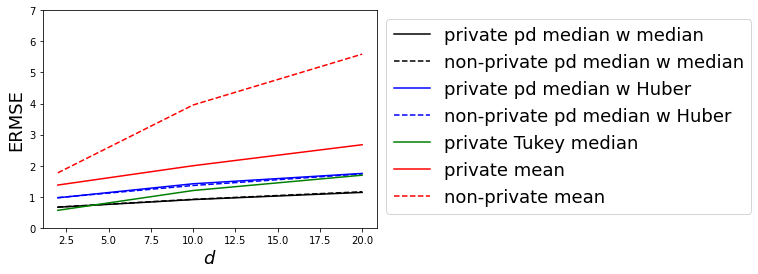

In [15]:
# save figure an plot in notebook
fig, ax = plt.subplots()

ax.plot(dimensions,np.sqrt(mses_con1),color='black',label=r'private pd median w median', linestyle='-')
ax.plot(dimensions,np.sqrt(mses_con2),color='black',label=r'non-private pd median w median', linestyle='--')
ax.plot(dimensions,np.sqrt(mses_con3),color='blue',label=r'private pd median w Huber', linestyle='-')
ax.plot(dimensions,np.sqrt(mses_con4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax.plot(dimensions,np.sqrt(mses_con5),color='green',label=r'private Tukey median', linestyle='-')
# plt.plot(dimensions,np.sqrt(mses_con2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax.plot(dimensions,np.sqrt(mses_con7),color='red',label=r'private mean', linestyle='-')
ax.plot(dimensions,np.sqrt(mses_con8),color="red",label=r'non-private mean', linestyle='--')
# ax.legend(fontsize=18)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=18)
# plt.show()
plt.ylim(0,7)
plt.ylabel('ERMSE', fontsize=18)
plt.xlabel(r'$d$', fontsize=18)
fname="con_gaussian.png"
plt.savefig(fname,dpi=600, bbox_inches='tight')
plt.show()

In [16]:
# Now make graphs for manuscript
viridis = cm.get_cmap('viridis', 8)
colors= viridis(range(8))
d=10
def get_mses(d):
    fn_mm="output/delta_med_mad_results_clean_dimension_"+str(d)+".pickle"
    fn_hm="output/hub_mad_results_clean_dimension_"+str(d)+".pickle"
    with open(fn_mm,"rb") as file:
        results_mm=pickle.load(file)
    with open(fn_hm,"rb") as file:
        results_hm=pickle.load(file)
    # print(len(results))
    x_pdmm_mse=0
    x_npdmm_mse=0
    for i in tqdm(results_mm):
        x_pdmm,x_npdmm = i
        x_pdmm=  np.array([x.get() for x in x_pdmm])
        x_npdmm = np.array([x.get() for x in x_npdmm])
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_pdmm_mse=x_pdmm_mse+np.linalg.norm(x_pdmm[x_pdmm.shape[0]-1,:])**2
        x_npdmm_mse=x_npdmm_mse+np.linalg.norm(x_npdmm[x_npdmm.shape[0]-1,:])**2
    
    x_pdhm_mse=0
    x_npdhm_mse=0
    for i in tqdm(results_hm):
        x_pdhm,x_npdhm = i
        x_pdhm=  np.array([x.get() for x in x_pdhm])
        x_npdhm = np.array([x.get() for x in x_npdhm])
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_pdhm_mse=x_pdhm_mse+np.linalg.norm(x_pdhm[x_pdhm.shape[0]-1,:])**2
        x_npdhm_mse=x_npdhm_mse+np.linalg.norm(x_npdhm[x_npdhm.shape[0]-1,:])**2
    x_pdhm_mse=x_pdhm_mse/len(results_hm)
    x_pdmm_mse=x_pdmm_mse/len(results_mm)
    x_npdhm_mse=x_npdhm_mse/len(results_hm)
    x_npdmm_mse=x_npdmm_mse/len(results_mm)
    # Other medians /means
    others_dir="C:/Users/12RAM/OneDrive - York University/Pre York Research/PhD Thesis/EM_Concentration_Paper/simulations/"
    fn=others_dir+"output/results_mis_prior_dimension_"+str(d)+".pickle"
    with open(fn,"rb") as file:
        results=pickle.load(file)
    # print(len(results))
    x_p_mse=0
    x_np_mse=0
    x_cp_mse=0
    for i in tqdm(results):
        x_p,x_np,x_cp = i
        x_p = np.array(x_p)
        x_np = np.array(x_np)
        x_cp = np.array(x_cp)
        # print(x_p.shape)
        # print(x_np.shape)
        # print(x_cp.shape)
        x_p_mse=x_p_mse+np.linalg.norm(x_p[x_p.shape[0]-1,:])**2
        x_np_mse=x_np_mse+np.linalg.norm(x_np[x_np.shape[0]-1,:])**2
        x_cp_mse=x_cp_mse+np.linalg.norm(x_cp)**2
    
    x_p_mse=x_p_mse/len(results)
    x_np_mse=x_np_mse/len(results)
    x_cp_mse=x_cp_mse/len(results)

    fn_m=others_dir+"output/np_mean_clean_"+str(d)+".pickle"
    with open(fn_m,"rb") as file:
        results_mean=pickle.load(file)
    x_npm_mse=np.mean(np.apply_along_axis(np.linalg.norm, 1, results_mean)**2)

    # print(x_p_mse)
    # print(x_np_mse)
    # print(x_cp_mse)
    # print(x_npm_mse)
    return x_pdmm_mse,x_npdmm_mse, x_pdhm_mse,x_npdhm_mse, x_p_mse, x_np_mse, x_cp_mse, x_npm_mse


get_mses(d)
dimensions=[2,10,20]
mses1=[]
mses2=[]
mses3=[]
mses4=[]
mses5=[]
mses6=[]
mses7=[]
mses8=[]
for d in dimensions:
    ms1,ms2,ms3,ms4,ms5,ms6,ms7,ms8=get_mses(d)
    mses1.append(ms1)
    mses2.append(ms2)
    mses3.append(ms3)
    mses4.append(ms4)
    mses5.append(ms5)
    mses6.append(ms6)
    mses7.append(ms7)
    mses8.append(ms8)

    

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1999.55it/s]


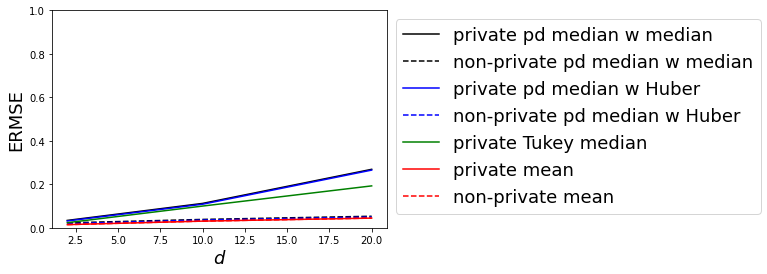

In [74]:
# save figure an plot in notebook
fig, ax = plt.subplots()

ax.plot(dimensions,np.sqrt(mses1),color='black',label=r'private pd median w median', linestyle='-')
ax.plot(dimensions,np.sqrt(mses2),color='black',label=r'non-private pd median w median', linestyle='--')
ax.plot(dimensions,np.sqrt(mses3),color='blue',label=r'private pd median w Huber', linestyle='-')
ax.plot(dimensions,np.sqrt(mses4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax.plot(dimensions,np.sqrt(mses5),color='green',label=r'private Tukey median', linestyle='-')
# plt.plot(dimensions,np.sqrt(mses2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax.plot(dimensions,np.sqrt(mses7),color='red',label=r'private mean', linestyle='-')
ax.plot(dimensions,np.sqrt(mses8),color="red",label=r'non-private mean', linestyle='--')
# ax.legend(fontsize=18)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=18)
# plt.show()
plt.ylim(0,1)
plt.ylabel('ERMSE', fontsize=18)
plt.xlabel(r'$d$', fontsize=18)
fname="clean_gaussian.png"
plt.savefig(fname,dpi=600)
plt.show()

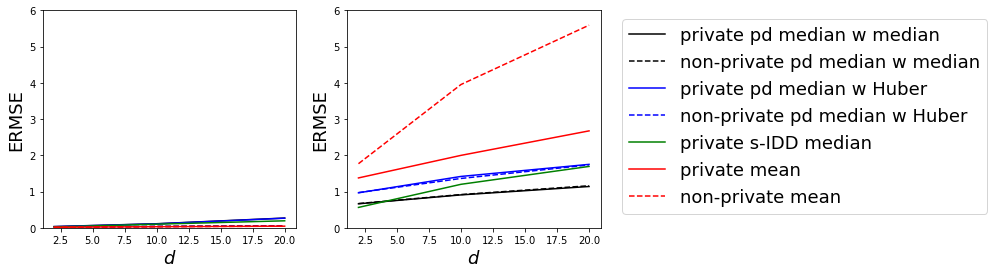

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax2.plot(dimensions,np.sqrt(mses_con1),color='black',label=r'private pd median w median', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con2),color='black',label=r'non-private pd median w median', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con3),color='blue',label=r'private pd median w Huber', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con5),color='green',label=r'private Tukey median', linestyle='-')
# plt.plot(dimensions,np.sqrt(mses_con2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con7),color='red',label=r'private mean', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con8),color="red",label=r'non-private mean', linestyle='--')
ax2.set_ylim(0,6)
ax2.set_ylabel('ERMSE', fontsize=18)
ax2.set_xlabel(r'$d$', fontsize=18)
# fname="con_gaussian.png"
# plt.savefig(fname,dpi=600, bbox_inches='tight')



ax1.plot(dimensions,np.sqrt(mses1),color='black',label=r'private pd median w median', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses2),color='black',label=r'non-private pd median w median', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses3),color='blue',label=r'private pd median w Huber', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses5),color='green',label=r'private s-IDD median', linestyle='-')
# plt.plot(dimensions,np.sqrt(mses2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses7),color='red',label=r'private mean', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses8),color="red",label=r'non-private mean', linestyle='--')
# ax.legend(fontsize=18)
# legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=18)
# plt.show()
ax1.set_ylim(0,6)
ax1.set_ylabel('ERMSE', fontsize=18)
ax1.set_xlabel(r'$d$', fontsize=18)
legend = ax1.legend(loc='upper left', bbox_to_anchor=(2.25, 1),fontsize=18)
fname="both_graphs.png"
plt.savefig(fname,dpi=600, bbox_inches='tight')
plt.show()

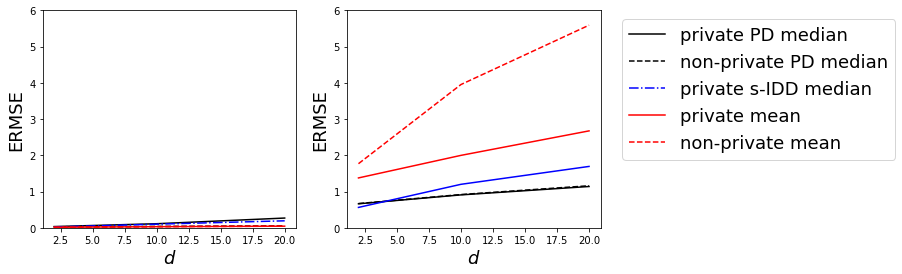

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax2.plot(dimensions,np.sqrt(mses_con1),color='black',label=r'private pd median', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con2),color='black',label=r'non-private pd median', linestyle='--')
# ax2.plot(dimensions,np.sqrt(mses_con3),color='blue',label=r'private pd median w Huber', linestyle='-')
# ax2.plot(dimensions,np.sqrt(mses_con4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con5),color='blue',label=r'private Tukey median', linestyle='-')
# plt.plot(dimensions,np.sqrt(mses_con2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con7),color='red',label=r'private mean', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con8),color="red",label=r'non-private mean', linestyle='--')
ax2.set_ylim(0,6)
ax2.set_ylabel('ERMSE', fontsize=18)
ax2.set_xlabel(r'$d$', fontsize=18)
# fname="con_gaussian.png"
# plt.savefig(fname,dpi=600, bbox_inches='tight')



ax1.plot(dimensions,np.sqrt(mses1),color='black',label=r'private PD median', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses2),color='black',label=r'non-private PD median', linestyle='--')
# ax1.plot(dimensions,np.sqrt(mses3),color='blue',label=r'private pd median w Huber', linestyle='-')
# ax1.plot(dimensions,np.sqrt(mses4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses5),color='blue',label=r'private s-IDD median', linestyle='-.')
# plt.plot(dimensions,np.sqrt(mses2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses7),color='red',label=r'private mean', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses8),color="red",label=r'non-private mean', linestyle='--')
# ax.legend(fontsize=18)
# legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=18)
# plt.show()
ax1.set_ylim(0,6)
ax1.set_ylabel('ERMSE', fontsize=18)
ax1.set_xlabel(r'$d$', fontsize=18)
legend = ax1.legend(loc='upper left', bbox_to_anchor=(2.25, 1),fontsize=18)
fname="both_graphs.png"
plt.savefig(fname,dpi=600, bbox_inches='tight')
plt.show()

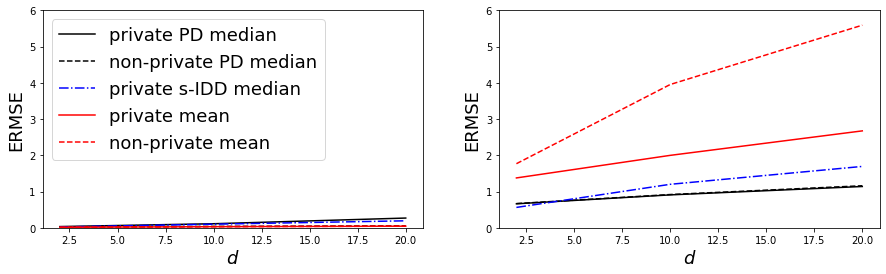

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))


ax2.plot(dimensions,np.sqrt(mses_con1),color='black',label=r'private pd median', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con2),color='black',label=r'non-private pd median', linestyle='--')
# ax2.plot(dimensions,np.sqrt(mses_con3),color='blue',label=r'private pd median w Huber', linestyle='-')
# ax2.plot(dimensions,np.sqrt(mses_con4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con5),color='blue',label=r'private s-IDD median', linestyle='-.')
# plt.plot(dimensions,np.sqrt(mses_con2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax2.plot(dimensions,np.sqrt(mses_con7),color='red',label=r'private mean', linestyle='-')
ax2.plot(dimensions,np.sqrt(mses_con8),color="red",label=r'non-private mean', linestyle='--')
ax2.set_ylim(0,6)
ax2.set_ylabel('ERMSE', fontsize=18)
ax2.set_xlabel(r'$d$', fontsize=18)

# fname="con_gaussian.png"
# plt.savefig(fname,dpi=600, bbox_inches='tight')



ax1.plot(dimensions,np.sqrt(mses1),color='black',label=r'private PD median', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses2),color='black',label=r'non-private PD median', linestyle='--')
# ax1.plot(dimensions,np.sqrt(mses3),color='blue',label=r'private pd median w Huber', linestyle='-')
# ax1.plot(dimensions,np.sqrt(mses4),color='blue',label=r'non-private pd median w Huber', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses5),color='blue',label=r'private s-IDD median', linestyle='-.')
# plt.plot(dimensions,np.sqrt(mses2),color=colors[3],label=r'non-private Tukey median', linestyle='--')
ax1.plot(dimensions,np.sqrt(mses7),color='red',label=r'private mean', linestyle='-')
ax1.plot(dimensions,np.sqrt(mses8),color="red",label=r'non-private mean', linestyle='--')
legend = ax1.legend(loc='upper left',fontsize=18)
# ax.legend(fontsize=18)
# legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=18)
# plt.show()
ax1.set_ylim(0,6)
ax1.set_ylabel('ERMSE', fontsize=18)
ax1.set_xlabel(r'$d$', fontsize=18)
fname="both_graphs2.png"
plt.savefig(fname,dpi=600, bbox_inches='tight')
plt.show()

In [10]:
import os
os.getcwd()

'C:\\Users\\12RAM\\OneDrive - York University\\Research\\Privacy Propose Test Release\\Simulations'